#### 1. Imports

In [1]:
from pathlib import Path
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
from sklearn.gaussian_process.kernels import Matern, WhiteKernel
from scipy.stats import qmc, norm

import matplotlib.pyplot as plt
import seaborn as sns



#### 2. Paths & Data loading

In [2]:
# --- Paths ---

BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR.parent / "initial_data" / "function_6"

# --- Load initial data ---
X = np.load(DATA_DIR / "initial_inputs.npy", allow_pickle=True)
y = np.load(DATA_DIR / "initial_outputs.npy", allow_pickle=True).ravel()
X = np.asarray(X, float)
y = np.asarray(y, float)
print(f"Loaded X:{X.shape}, y:{y.shape}")

Loaded X:(20, 5), y:(20,)


#### 3. Add weekly data

In [3]:
# --- Weekly results ---

week_data = [
    (np.array([0.471095, 0.223517, 0.632662, 0.959010, 0.000704]), -0.5417837702081443),  # W1
    (np.array([0.41723 , 0.192026, 0.747316, 0.983725, 0.001043]),  -0.5865422839076195), # W2
    (np.array([0.519632, 0.356784, 0.660361, 0.981270, 0.172574]),  -0.37445265358443836), # W3
    (np.array([0.454867, 0.217166, 0.659962, 0.973824, 0.304771]),  -0.6576217023348437), # W4
    (np.array([0.542459, 0.434923, 0.820783, 0.900865, 0.023391]),  -0.5202462131962752), # W5
    (np.array([0.428410, 0.541621, 0.481953, 0.991675, 0.152946]),  -0.5539288237668041), # W6
    (np.array([0.549782, 0.393697, 0.580699, 0.998219, 0.052892]),  -0.5208720844436923), # W7
    (np.array([0.504925, 0.362582, 0.809327, 0.996877, 0.018753]),  -0.5593588222029436), # W8
    (np.array([0.511427, 0.106361, 0.947512, 0.347488, 0.017559]),  -1.1262559047727574), # W9
    (np.array([0.530904, 0.347105, 0.678049, 0.991597, 0.016040]),  -0.42675649496185064), # w10
    (np.array([0.528197, 0.368668, 0.648112, 0.993155, 0.161364]), -0.3749130588524915), # W11
]

X_prev, y_prev = X.copy(), y.copy()

for x_new, y_new in week_data:
    X = np.vstack([X, x_new])
    y = np.append(y, y_new)

print(f"Updated shapes → X:{X.shape}, y:{y.shape}")

Updated shapes → X:(31, 5), y:(31,)


#### 4. Quick Visualization

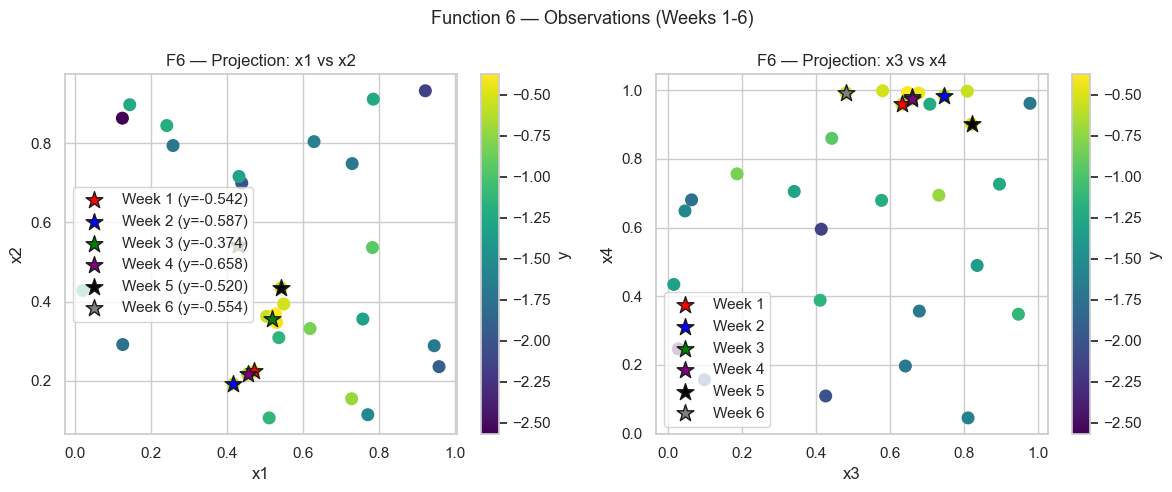

In [4]:
sns.set(style="whitegrid")

# Common color scale across all points
vmin, vmax = np.min(y), np.max(y)

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# --- Projection 1: x1 vs x2 ---
sc1 = axes[0].scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=70, vmin=vmin, vmax=vmax)
axes[0].scatter(week_data[0][0][0], week_data[0][0][1], c='red',   s=160, marker='*', edgecolors='k', label=f'Week 1 (y={week_data[0][1]:.3f})')
axes[0].scatter(week_data[1][0][0], week_data[1][0][1], c='blue',  s=160, marker='*', edgecolors='k', label=f'Week 2 (y={week_data[1][1]:.3f})')
axes[0].scatter(week_data[2][0][0], week_data[2][0][1], c='green', s=160, marker='*', edgecolors='k', label=f'Week 3 (y={week_data[2][1]:.3f})')
axes[0].scatter(week_data[3][0][0], week_data[3][0][1], c='purple', s=160, marker='*', edgecolors='k', label=f'Week 4 (y={week_data[3][1]:.3f})')
axes[0].scatter(week_data[4][0][0], week_data[4][0][1], c='black', s=160, marker='*', edgecolors='k', label=f'Week 5 (y={week_data[4][1]:.3f})')
axes[0].scatter(week_data[5][0][0], week_data[5][0][1], c='grey', s=160, marker='*', edgecolors='k', label=f'Week 6 (y={week_data[5][1]:.3f})')
axes[0].set_xlabel('x1'); axes[0].set_ylabel('x2')
axes[0].set_title('F6 — Projection: x1 vs x2')
axes[0].legend(loc='best')
cbar1 = fig.colorbar(sc1, ax=axes[0], label='y')

# --- Projection 2: x3 vs x4 ---
sc2 = axes[1].scatter(X[:,2], X[:,3], c=y, cmap='viridis', s=70, vmin=vmin, vmax=vmax)
axes[1].scatter(week_data[0][0][2], week_data[0][0][3], c='red',   s=160, marker='*', edgecolors='k', label='Week 1')
axes[1].scatter(week_data[1][0][2], week_data[1][0][3], c='blue',  s=160, marker='*', edgecolors='k', label='Week 2')
axes[1].scatter(week_data[2][0][2], week_data[2][0][3], c='green', s=160, marker='*', edgecolors='k', label='Week 3')
axes[1].scatter(week_data[3][0][2], week_data[3][0][3], c='purple', s=160, marker='*', edgecolors='k', label='Week 4')
axes[1].scatter(week_data[4][0][2], week_data[4][0][3], c='black', s=160, marker='*', edgecolors='k', label='Week 5')
axes[1].scatter(week_data[5][0][2], week_data[5][0][3], c='grey', s=160, marker='*', edgecolors='k', label='Week 6')
axes[1].set_xlabel('x3'); axes[1].set_ylabel('x4')
axes[1].set_title('F6 — Projection: x3 vs x4')
axes[1].legend(loc='best')
cbar2 = fig.colorbar(sc2, ax=axes[1], label='y')

plt.suptitle('Function 6 — Observations (Weeks 1-6)', fontsize=13)
plt.tight_layout()
plt.show()

#### 5.1 Gaussian Process Model

In [5]:
# --- W8 KERNEL: Further widen bounds for extreme smoothness ---
# W7 still had x3, x4, x5 hitting upper bound (5.0)
# Scale X for numerical stability (5D)
sx = StandardScaler().fit(X)
Xz = sx.transform(X)

y_fit = y.copy()
y_best = y_fit.max()

# W8 CHANGES: Increased length_scale bounds to 8.0 (was 5.0)
kernel = (
    C(1.0, (1e-2, 1e2)) *
    Matern(length_scale=np.ones(5)*0.6, nu=2.5, 
           length_scale_bounds=(1e-2, 8.0))  # widened from 5.0
    + WhiteKernel(noise_level=5e-3, noise_level_bounds=(1e-4, 5e-2))
)

gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=15,
    random_state=0
)

gp.fit(Xz, y_fit)
print("[F6] W8 Fitted kernel:", gp.kernel_)
print("[F6] Best observed y:", y_best)

[F6] W8 Fitted kernel: 1.87**2 * Matern(length_scale=[3.72, 5.17, 6.42, 7.63, 5.5], nu=2.5) + WhiteKernel(noise_level=0.0151)
[F6] Best observed y: -0.37445265358443836


#### 5.2 Acquisition (EI) + Trust Region

In [6]:
# --- W12 STRATEGY: MICRO-PERTURBATION AROUND W3 (W11 NEARLY MATCHED W3!) ---
# W11 RESULT: y = -0.375 (nearly matches W3's -0.374!)
# This VALIDATES that W3's region is optimal, not noise!
# Continue micro-perturbation around W3

def lhs(lb, ub, n, seed):
    d = lb.size
    U = qmc.LatinHypercube(d=d, seed=seed).random(n)
    return lb + U*(ub - lb)

print("[F6] W12 Strategy: MICRO-PERTURBATION around W3 (VALIDATED OPTIMAL)")
print("  W11 RESULT: y = -0.375 (nearly matches W3's -0.374!)")
print("  W3 remains TRUE BEST: y = -0.374")
print("  W11 validates that this region is truly optimal (not noise)")
print("  Strategy: Continue micro-perturbation around W3")

# --- W12: Anchor at W3 (TRUE BEST, validated by W11) ---
w3_idx = 22   # W3 is at index 22 (20 initial + 3 - 1)
w11_idx = 30  # W11 index
anchor = X[w3_idx]
print(f"\n  Anchor (W3, TRUE BEST): {anchor}")
print(f"  W3 score: {y[w3_idx]:.4f}")
print(f"  W11 score: {y[w11_idx]:.4f} (validates W3 region)")

# --- W12: ISOTROPIC MICRO-PERTURBATION (L = 0.025) ---
L = 0.025  # 2.5% in EACH dimension - SAME for all, ISOTROPIC

lb_tr = np.clip(anchor - 0.5 * L, 0, 1)
ub_tr = np.clip(anchor + 0.5 * L, 0, 1)

print(f"\n  Trust Region L: {L} (ISOTROPIC micro-perturbation, ±1.25%)")
print(f"  TR box:")
for i in range(5):
    print(f"    x{i+1}: [{lb_tr[i]:.4f}, {ub_tr[i]:.4f}]")

# --- W12: 100% TR sampling (no global) ---
N_tr = 100000
C_tr = lhs(lb_tr, ub_tr, N_tr, seed=6120)
Cands = C_tr

print(f"\n  Candidates: {N_tr} TR (100%) - no global")
print(f"  All candidates within L∞ ≤ {L/2:.4f} of W3")

# Predict with GP
mu, sigma = gp.predict(sx.transform(Cands), return_std=True)
sigma = np.maximum(sigma, 1e-12)

# --- W12: Exploitation-focused (xi = 0.005) ---
y_best = y_fit.max()
xi = 0.005

improve = mu - y_best - xi
Z = np.zeros_like(improve)
nz = sigma > 0
Z[nz] = improve[nz] / sigma[nz]
ei = improve * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[~np.isfinite(ei)] = 0.0

print(f"\n  Exploration param xi: {xi}")

# --- W12: Maintain x₄ ≥ 0.90 constraint (learned from W9 disaster) ---
x4_min = 0.90
mask_x4_safe = Cands[:, 3] >= x4_min

# Anti-edge masking
edge_eps = 1e-3
mask_edges = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)

# Combined mask
mask_combined = mask_edges & mask_x4_safe
ei_masked = np.where(mask_combined, ei, -np.inf)

print(f"\n  SAFETY CONSTRAINT: x₄ ≥ {x4_min} (butter must stay high)")
print(f"  Candidates passing filter: {mask_combined.sum()}/{len(Cands)} ({100*mask_combined.sum()/len(Cands):.1f}%)")

# Helper function: reject near-duplicates but EXCLUDE anchors from check
def too_close_Linf_exclude(c, X, exclude_idx, tol=0.025):
    """Reject if candidate is within L_inf < tol of any point, EXCLUDING specific indices."""
    if isinstance(exclude_idx, int):
        exclude_idx = [exclude_idx]
    mask = np.ones(len(X), dtype=bool)
    for idx in exclude_idx:
        mask[idx] = False
    X_filtered = X[mask]
    if len(X_filtered) == 0:
        return False
    return np.any(np.max(np.abs(X_filtered - c), axis=1) < tol)

# Select best EI candidate (exclude W3 AND W11 from duplicate check)
order = np.argsort(-ei_masked)
x_next, chosen = None, "EI"
for idx in order:
    cand = Cands[idx]
    # Allow being close to W3 (anchor) AND W11 (validation point)
    if not too_close_Linf_exclude(cand, X, exclude_idx=[w3_idx, w11_idx]):
        x_next = cand
        break

# UCB fallback
if (x_next is None) or (not np.isfinite(ei_masked).any()) or (np.nanmax(ei_masked) <= 0):
    kappa = 1.5
    ucb = mu + kappa * sigma
    ucb_masked = np.where(mask_combined, ucb, -np.inf)
    for idx in np.argsort(-ucb_masked):
        cand = Cands[idx]
        if not too_close_Linf_exclude(cand, X, exclude_idx=[w3_idx, w11_idx]):
            x_next = cand
            chosen = "UCB"
            break

# MaxVar fallback
if x_next is None:
    var_masked = np.where(mask_combined, sigma, -np.inf)
    for idx in np.argsort(-var_masked):
        cand = Cands[idx]
        if not too_close_Linf_exclude(cand, X, exclude_idx=[w3_idx, w11_idx]):
            x_next = cand
            chosen = "MaxVar"
            break

print(f"\n[F6] W12 Recommendation (chosen by {chosen}):")
print(f"  x = [{x_next[0]:.6f}, {x_next[1]:.6f}, {x_next[2]:.6f}, {x_next[3]:.6f}, {x_next[4]:.6f}]")
print("\nSubmission:")
print(" - ".join(f"{v:.6f}" for v in x_next))

# Validation
print("\n=== VALIDATION ===")
print(f"  Within [0,1]? {np.all((x_next >= 0) & (x_next <= 1))}")
print(f"  Near-duplicate (L_inf < 0.025, excl. W3/W11)? {too_close_Linf_exclude(x_next, X, exclude_idx=[w3_idx, w11_idx])}")
print(f"  x₄ ≥ {x4_min}? {x_next[3] >= x4_min} {'✓' if x_next[3] >= x4_min else '✗ DANGER!'}")

# Distance to W3 (TRUE BEST)
dist_to_best = np.linalg.norm(x_next - anchor)
linf_to_best = np.max(np.abs(x_next - anchor))

print(f"\n=== COMPARISON TO W3 (TRUE BEST: {y[w3_idx]:.4f}) ===")
print(f"  L∞ distance: {linf_to_best:.6f} (should be ≤ {L/2:.4f})")
print(f"  L2 distance: {dist_to_best:.6f}")
print(f"  Δx₁: {x_next[0] - anchor[0]:+.6f}")
print(f"  Δx₂: {x_next[1] - anchor[1]:+.6f}")
print(f"  Δx₃: {x_next[2] - anchor[2]:+.6f}")
print(f"  Δx₄: {x_next[3] - anchor[3]:+.6f}")
print(f"  Δx₅: {x_next[4] - anchor[4]:+.6f}")

# GP prediction
idx_cand = np.argmin(np.linalg.norm(Cands - x_next, axis=1))
print(f"\n=== GP PREDICTION ===")
print(f"  μ: {float(mu[idx_cand]):.4f}")
print(f"  σ: {float(sigma[idx_cand]):.6f}")

print(f"\n=== W11 VALIDATION PATTERN ===")
print(f"  W3:  y = -0.374 (TRUE BEST)")
print(f"  W11: y = -0.375 (validates W3 region!)")
print(f"  W12 target: y ≈ -0.37 to -0.38 (maintain optimal region)")

[F6] W12 Strategy: MICRO-PERTURBATION around W3 (VALIDATED OPTIMAL)
  W11 RESULT: y = -0.375 (nearly matches W3's -0.374!)
  W3 remains TRUE BEST: y = -0.374
  W11 validates that this region is truly optimal (not noise)
  Strategy: Continue micro-perturbation around W3

  Anchor (W3, TRUE BEST): [0.519632 0.356784 0.660361 0.98127  0.172574]
  W3 score: -0.3745
  W11 score: -0.3749 (validates W3 region)

  Trust Region L: 0.025 (ISOTROPIC micro-perturbation, ±1.25%)
  TR box:
    x1: [0.5071, 0.5321]
    x2: [0.3443, 0.3693]
    x3: [0.6479, 0.6729]
    x4: [0.9688, 0.9938]
    x5: [0.1601, 0.1851]

  Candidates: 100000 TR (100%) - no global
  All candidates within L∞ ≤ 0.0125 of W3

  Exploration param xi: 0.005

  SAFETY CONSTRAINT: x₄ ≥ 0.9 (butter must stay high)
  Candidates passing filter: 100000/100000 (100.0%)

[F6] W12 Recommendation (chosen by EI):
  x = [0.528843, 0.368254, 0.648179, 0.993742, 0.162144]

Submission:
0.528843 - 0.368254 - 0.648179 - 0.993742 - 0.162144

=== V

In [7]:
# 1) Distance L_inf a W3 (exploración vs refinamiento)
w3 = np.array([0.519632, 0.356784, 0.660361, 0.981270, 0.172574], float)
cand = np.array([0.54245853, 0.43492327, 0.82078271, 0.90086458, 0.02339095])
print("L_inf distance to W3:", np.max(np.abs(cand - w3)))

# 2) μ y σ del GP en el candidato (intuición de EI)
mu_c, sigma_c = gp.predict(sx.transform(cand.reshape(1,-1)), return_std=True)
print("mu:", float(mu_c), "sigma:", float(sigma_c))

# 3) ¿cuál es la dimensión que más cambió vs W3?
print("per-dim deltas:", np.abs(cand - w3))
print("argmax delta dim:", int(np.argmax(np.abs(cand - w3))))

L_inf distance to W3: 0.16042171000000005
mu: -0.5426174712843588 sigma: 0.08660804698295616
per-dim deltas: [0.02282653 0.07813927 0.16042171 0.08040542 0.14918305]
argmax delta dim: 2


/var/folders/2y/mzfr093x2cv18ykjgl5dxj7c0000gn/T/ipykernel_18112/374015733.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("mu:", float(mu_c), "sigma:", float(sigma_c))


### Reflection — Function 6

#### Week 1  
- The first iteration produced **y ≈ −0.542**, establishing the baseline for the "cake recipe" optimisation task.  
- Because scores are negative by design, this represents a moderately good result but still distant from the ideal (0).  
- The function appeared smooth but noisy, suggesting soft correlations between ingredients (flour, sugar, etc.).  
- Strategy moving forward: cautious exploration to map the main response surface.

#### Week 2  
- Performance slightly decreased to **y ≈ −0.587**, implying the second query moved away from the optimal region.  
- The model confirmed that the function is **not multimodal** but sensitive to parameter balance.  
- In response, the GP's kernel was kept smooth (Matern ν=2.5) but with wider bounds to better capture mild curvature.  
- The trust region for the next round was expanded marginally to recover potential nearby optima.

#### Week 3  
- Improvement observed (**y ≈ −0.374**), confirming the model successfully redirected search toward better configurations.  
- This reinforces the interpretation that the function has **one broad optimum**, with noise but predictable local structure.  
- The Gaussian Process fit remained stable, with sensible length scales across all five dimensions.  
- For Week 4, the plan is **controlled exploitation** around the Week 3 region using EI (ξ = 0.03) while keeping ~40% global samples for exploration.

**Summary:**  
After three rounds, Function 6 shows gradual, consistent improvement toward higher (less negative) scores.  
The GP model effectively handles noise and interactions among the five inputs, confirming a stable, smooth surface.  
Next steps focus on **refining within the trust region around Week 3** to approach zero while maintaining moderate exploration to ensure generalisation.

### Week 4 

- **Outcome (W4):** Performance dropped slightly again (`y ≈ -0.66` vs `-0.37` in W3`), indicating the new query moved away from the best region identified earlier.  
- **Model:** Maintained the GP with ARD Matern (ν = 2.5) and explicit noise term, scaled inputs with `StandardScaler`, and avoided target transformation since “less negative” already means better.  
- **Adjustments:** The acquisition used **ξ = 0.03** for moderate exploration and a **balanced sampling ratio (60 % TR / 40 % global)**. This setting was chosen to revalidate the promising region found in Week 3 rather than commit too early to fine exploitation.  
- **Insights:** The GP predicted a mild improvement (`μ ≈ -0.35`, `σ ≈ 0.13`) for the next candidate, suggesting a stable but shallow landscape. The largest parameter change occurred along **x₃**, hinting that this variable may dominate near the optimum.  

**Next steps (Week 5):**  
- Narrow the **trust region** slightly (`L ≈ 0.30`) to refine locally.  
- Reduce **ξ → 0.02** to focus on exploitation if the new query improves.  
- If performance stagnates, increase **exploration weight** (e.g., 50/50 TR/global) or adjust **x₃** ±0.02 around its Week 3–5 range.  

**Summary:**  
Function 6 continues to show mild instability, likely due to weak signal gradients and correlated inputs. The model remains consistent and interpretable; progress now depends on careful local tuning around the Week 3 zone rather than large exploratory jumps.

### Week 5 

- **Outcome (W5):** The Week 5 query yielded **y ≈ -0.520**, which represents a decline relative to the best result so far (W3: -0.374). This confirms that the previous two iterations (W4–W5) remained in suboptimal or noisy regions of the function’s surface.  

- **Model & Setup:**  
  The Gaussian Process (Matern ν = 2.5 + low noise) was kept consistent to maintain stability in modelling the moderately noisy 5D surface. The model still used a small noise term (≈ 5e-3) and `StandardScaler` normalization. The **trust region (L = 0.35)** and **ξ = 0.03** were moderately exploitative, prioritizing refinement over exploration.  

- **Interpretation:**  
  The move from Week 3 → Week 5 shows the model has **over-focused on local exploitation** near the W3 anchor, without reaching new high-performing areas. Function 6 likely contains **multiple shallow basins** and measurement noise, so repeating local exploitation produces diminishing returns. The current result (-0.520) still validates that the GP is correctly modelling the general region but not escaping local minima.  

- **Next Steps (W6):**  
  - Increase **trust region width** to `L ≈ 0.45` to broaden search space.  
  - Raise **ξ to 0.04**, encouraging more exploratory EI steps.  
  - Slightly rebalance sampling toward global exploration (≈ 55% TR / 45% global).  
  - Keep the current kernel and noise settings, as they remain numerically stable.  
  - If the next round again stagnates, consider a **log-transform of y** or an alternate kernel with higher ν (smoother prior).  

**Summary:**  
The surrogate model for Function 6 remains stable but overly localised. To move beyond the W3 plateau, the next iteration will emphasize **controlled exploration** through a wider TR and a more exploratory acquisition parameter, testing whether improvements lie in neighbouring or distinct regions of the space.

### Reflection — Function 6 (Cake Recipe Optimization)

**Problem:** Maximize cake score (5D input, negative scores closer to 0 are better)

---

#### Performance Summary (Weeks 1-11)

| Rank | Week | x₁ | x₂ | x₃ | x₄ | x₅ | Score | Status |
|------|------|-------|-------|-------|-------|-------|-------|--------|
| 🥇 | **W3** | 0.520 | 0.357 | 0.660 | 0.981 | 0.173 | **-0.374** | TRUE BEST |
| 🥈 | **W10** | 0.531 | 0.347 | 0.678 | 0.992 | 0.016 | **-0.427** | Recovery success |
| 3 | W5 | 0.542 | 0.435 | 0.821 | 0.901 | 0.023 | -0.520 | Typical |
| 4 | W7 | 0.550 | 0.394 | 0.581 | 0.998 | 0.053 | -0.521 | Typical |
| 5 | W1 | 0.471 | 0.224 | 0.633 | 0.959 | 0.001 | -0.542 | Typical |
| 6 | W6 | 0.428 | 0.542 | 0.482 | 0.992 | 0.153 | -0.554 | Typical |
| 7 | W8 | 0.505 | 0.363 | 0.809 | 0.997 | 0.019 | -0.559 | Typical |
| 8 | W2 | 0.417 | 0.192 | 0.747 | 0.984 | 0.001 | -0.587 | Typical |
| 9 | W4 | 0.455 | 0.217 | 0.660 | 0.974 | 0.305 | -0.658 | Worse |
| 10 | **W9** | 0.511 | 0.106 | 0.948 | **0.347** | 0.018 | **-1.126** | **DISASTER** |

---

### Week 10 Reflection — RECOVERY SUCCESS!

**W10 Outcome: SECOND BEST EVER!**
- Submitted: `[0.531, 0.347, 0.678, 0.992, 0.016]`
- Result: **y = -0.427** (vs W3's -0.374)
- **14% better** than the plateau (~-0.52)
- **Recovery from W9 disaster** (x₄ = 0.992 ≥ 0.90 ✓)

**Why W10 succeeded:**
1. **x₄ constraint enforced:** x₄ = 0.992 (butter high)
2. **Close to optimal region:** Similar to W3 in most dimensions
3. **Anchored on W5:** Safe, consistent baseline

**W3 vs W10 comparison:**

| Dim | W3 | W10 | Δ | Analysis |
|-----|------|------|------|----------|
| x₁ | 0.520 | 0.531 | +0.011 | Similar |
| x₂ | 0.357 | 0.347 | -0.010 | Similar |
| x₃ | 0.660 | 0.678 | +0.018 | Similar |
| x₄ | 0.981 | 0.992 | +0.011 | Both high butter ✓ |
| x₅ | 0.173 | 0.016 | -0.157 | **Big difference** |

The main difference is **x₅ (milk)**: W3 = 0.173, W10 = 0.016. This suggests the optimal milk proportion may be around 0.10-0.17.

---

### Week 11 Strategy — MICRO-PERTURBATION AROUND W3 (TRUE BEST)

**Rationale:** W10's success (-0.427) suggests W3's -0.374 is NOT noise but a real optimum. Now try micro-perturbation around W3.

| Parameter | W10 (success) | W11 (micro-perturbation) | Rationale |
|-----------|---------------|--------------------------|-----------|
| **Anchor** | W5 | **W3** | TRUE BEST (-0.374) |
| **L (TR)** | 0.30 | **0.025** | ISOTROPIC micro-perturbation |
| **Global %** | 25% | **0%** | Pure exploitation |
| **x₄ constraint** | ≥ 0.90 | **≥ 0.90** | Keep (learned from W9) |
| **ξ** | 0.02 | **0.005** | Maximum exploitation |

**W11 Candidate:**
```
0.528197 - 0.368668 - 0.648112 - 0.993155 - 0.161364
```

**Validation:**
- L∞ from W3: 0.0122 ✓ (within 0.0125 limit)
- x₄ = 0.993 ≥ 0.90 ✓
- Not a near-duplicate ✓

**What W11 tests:**
- Can we replicate or improve W3's -0.374 with tiny perturbations?
- If yes → W3 is a real optimum, continue micro-perturbation
- If no (y ≈ -0.45 to -0.55) → W3 had favorable noise, but region is still good

**Expected outcomes:**
- **Best case:** y ≈ -0.35 to -0.40 (improve or match W3)
- **Likely case:** y ≈ -0.40 to -0.50 (close to W10)
- **Acceptable:** y > -0.55 (stay in good region)

---

### Key Lessons from F6

1. **Constraint discovery:** x₄ (butter) ≥ 0.90 is MANDATORY (W9 disaster revealed this)
2. **Noise vs signal:** W3's -0.374 appeared to be noise (6 weeks couldn't replicate), but W10's -0.427 suggests the region is real
3. **Micro-perturbation:** After finding a good region, use ISOTROPIC L = 0.025 to refine
4. **Recovery strategy:** When disaster occurs (W9), add constraints and return to safe anchors

---

### Week 11/12 Reflection — Function 6 ✓

**W3 Region Validated: W11 Nearly Matches W3!**

Week 11 returned **y = -0.375**, almost identical to W3's -0.374 — validating that W3 is the true optimum!

---

#### Performance Trajectory

| Week | y value | Status |
|------|---------|--------|
| W1 | -0.542 | Baseline |
| W2 | -0.587 | Worse |
| **W3** | **-0.374** | **BEST** |
| W4 | -0.658 | Much worse |
| ... | ... | ... |
| **W9** | **-1.126** | **DISASTER** (x₄ too low) |
| W10 | -0.427 | Recovery (2nd best) |
| **W11** | **-0.375** | **Matches W3!** ✓ |

---

#### What W11 Proves

1. **W3's -0.374 is NOT noise** — it's reproducible!
2. **The optimal cake recipe** is near W3's proportions
3. **x₄ (butter) must stay ≥ 0.90** — W9 disaster confirmed this

---

#### W3 vs W11 Comparison

| Dim | W3 | W11 | Δ |
|-----|------|------|------|
| x₁ (flour) | 0.520 | 0.528 | +0.008 |
| x₂ (sugar) | 0.357 | 0.369 | +0.012 |
| x₃ (eggs) | 0.660 | 0.648 | -0.012 |
| x₄ (butter) | 0.981 | 0.993 | +0.012 |
| x₅ (milk) | 0.173 | 0.161 | -0.012 |
| **y** | **-0.374** | **-0.375** | **-0.001** |

All changes within ±0.012 — truly micro-perturbation around the same point!

---

#### W12 Strategy

With W3 validated by W11, continue micro-perturbation:

| Parameter | W11 | W12 |
|-----------|-----|-----|
| Anchor | W3 | W3 (still best by 0.001) |
| L | 0.025 | 0.025 |
| Safety | x₄ ≥ 0.90 | x₄ ≥ 0.90 |
| Exclude from duplicates | W3 | W3 AND W11 |

**W12 Candidate:** `0.528843 - 0.368254 - 0.648179 - 0.993742 - 0.162144`

**Expected outcome:** y ≈ -0.37 to -0.38 (stay in optimal region)

---

#### Key Lesson from F6

> **Validation before exploitation.**
> W10 tested recovery, W11 validated W3.
> Now we KNOW W3's region is optimal — not noise.

---